# Receiving TDs Model

Josh Allen  
2025-10-23

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joshuafayallen/Fantasy-Football-Project/blob/main/fantasy-points-projection/expected_points/blob/main//Users/josh/Documents/football-project/fantasy-points-projection/expected_points/Formal-Writeup.ipynb)

## Introduction

In [1]:
import polars as pl
import pandas as pd
import pymc as pm
import preliz as pz
import numpy as np
from scipy.special import logit
import matplotlib.pyplot as plt
import arviz as az
import nflreadpy as nfl
import xarray as xr
import os
import subprocess

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

# seed = subprocess.run('curl "https://www.random.org/integers/?num=1&min=10000000&max=99999999&col=1&base=10&# format=plain&rnd=new"',
#     shell=True,
#     capture_output=True,
#     text=True)
rng = 87472715

full_pass_data = pl.scan_parquet("./processed_data/processed_passers_*.parquet").collect()

full_scores = nfl.load_schedules()

player_exp = nfl.load_players().select(
    pl.col("gsis_id", "display_name", "birth_date", "rookie_season")
)

## Pre-Processing

In [2]:
clean_full_scores = full_scores.select(
    pl.col(
        "game_id",
        "game_type",
        "home_rest",
        "week",
        "away_rest",
        "home_score",
        "away_score",
        "home_team",
        "away_team",
        "result",
        "total",
        "total_line",
        "div_game",
    )
)

rec_predictors = [
    "posteam",
    "off_play_caller",
    "receiver_full_name",
    "receiver_player_id",
    "receiving_yards",
    "week",
    "air_yards",
    "epa",
    "receiver_position",
    "surface",
    "no_huddle",
    "game_id",
    "yards_after_catch",
    "roof",
    "game_id",
    "complete_pass",
    "targeted",
    "defteam",
    "wind",
    "temp",
    "def_play_caller",
    "season",
    "total_pass_attempts",
    "pass_touchdown",
]


rec_data_full = (
    full_pass_data.join(clean_full_scores, on=["game_id"])
    .filter(pl.col("game_type") == "REG")
    .with_columns(
        pl.col("pass_attempt")
        .sum()
        .over(["receiver_full_name", "game_id"])
        .alias("targeted"),
        pl.col("pass_attempt")
        .sum()
        .over(["posteam", "game_id"])
        .alias("total_pass_attempts"),
    )
    .select(
        pl.col(rec_predictors),
        pl.col(
            "game_type",
            "home_rest",
            "away_rest",
            "home_score",
            "away_score",
            "home_team",
            "away_team",
            "result",
            "total",
            "total_line",
            "div_game",
        ),
    )
    .filter(
        (pl.col("yards_after_catch").is_not_null())
        & (pl.col("receiver_position").is_in(["RB", "TE", "WR"]))
    )
    .with_columns(
        pl.col("complete_pass")
        .str.to_integer()
        .count()
        .over("receiver_player_id", "season")
        .alias("receptions_season"),
        pl.col("complete_pass")
        .str.to_integer()
        .count()
        .over(["receiver_player_id", "game_id", "season"])
        .alias("receptions_per_game"),
        (pl.col("epa") * -1).alias("defensive_epa"),
    )
)


agg_full_seasons = (
    rec_data_full.with_columns(
        pl.col("yards_after_catch")
        .sum()
        .over(["receiver_full_name", "game_id", "season"])
        .alias("yac_per_game"),
        pl.col("receiving_yards")
        .sum()
        .over(["receiver_full_name", "game_id", "season"]),
        (pl.col("air_yards") / pl.col("total_pass_attempts"))
        .alias("avg_depth_of_target")
        .over(["posteam", "game_id", "season"]),
        (pl.col("receiving_yards") / pl.col("receptions_per_game")).alias(
            "yards_per_catch"
        ),
        pl.col("epa")
        .mean()
        .over(["game_id", "posteam", "season"])
        .alias("pass_epa_per_play"),
        pl.col("defensive_epa")
        .mean()
        .over(["game_id", "defteam", "season"])
        .alias("def_epa_per_play"),
        pl.col("pass_touchdown").str.to_integer(),
        pl.col("epa")
        .sum()
        .over(["game_id", "posteam", "season"])
        .alias("total_off_epa_game"),
        pl.col("defensive_epa")
        .sum()
        .over(["game_id", "defteam", "season"])
        .alias("total_def_epa_game"),
    )
    .with_columns(
        pl.col("pass_touchdown")
        .sum()
        .over(["receiver_full_name", "game_id", "season"])
        .alias("rec_tds_game")
    )
    .unique(subset=["game_id", "receiver_full_name", "season"])
    .select(
        # get rid of the per play to not have any confusion
        pl.exclude("epa", "defensive_epa")
    )
    .with_columns(
        pl.when(pl.col("rec_tds_game") > 0).then(1).otherwise(0).alias("rec_tds")
    )
    .with_columns(
        pl.col("rec_tds_game")
        .sum()
        .over(["receiver_full_name", "season"])
        .alias("rec_tds_season"),
    )
    .filter(
        pl.col("rec_tds_season") > 0
    )
)



construct_games_played = (
    agg_full_seasons.with_columns(
        pl.when(pl.col("posteam") == pl.col("home_team"))
        .then(pl.col("home_score"))
        .otherwise(pl.col("away_score"))
        .alias("player_team_score"),
        pl.when(pl.col("defteam") == pl.col("away_team"))
        .then(pl.col("away_score"))
        .otherwise(pl.col("home_score"))
        .alias("opponent_score"),
        pl.when(pl.col("posteam") == pl.col("home_team"))
        .then(pl.col("home_rest"))
        .otherwise(pl.col("away_rest"))
        .alias("player_rest"),
        pl.when(pl.col("defteam") == pl.col("away_team"))
        .then(pl.col("away_rest"))
        .otherwise(pl.col("home_rest"))
        .alias("opponent_rest"),
        pl.when(pl.col("posteam") == pl.col("home_team"))
        .then(1)
        .otherwise(0)
        .alias("home_game"),
    )
    .sort(["posteam", "season", "week", "receiver_full_name"])
    .with_columns(
        (pl.col("player_team_score") - pl.col("opponent_score")).alias(
            "player_team_score_diff"
        ),
        (pl.col("opponent_score") - pl.col("player_team_score")).alias(
            "opponent_score_diff"
        ),
        (pl.col("player_rest") - pl.col("opponent_rest")).alias("player_rest_diff"),
        (pl.col("opponent_rest") - pl.col("player_rest")).alias("opponent_rest_diff"),
        (pl.col("total_off_epa_game") - pl.col("total_def_epa_game")).alias(
            "receiver_epa_diff"
        ),
        (pl.col("total_def_epa_game") - pl.col("total_off_epa_game")).alias(
            "def_epa_diff"
        ),
    )
    .with_columns(
        pl.col("game_id")
        .cum_count()
        .over(["receiver_full_name", "season"])
        .alias("games_played"),
        (pl.col("receiving_yards") - pl.col("receiving_yards").mean()).alias(
            "receiving_yards_c"
        ),
    )
    .join(player_exp, left_on=["receiver_player_id"], right_on="gsis_id", how="left")
    .with_columns(
        (pl.col("season") - pl.col("rookie_season")).alias("number_of_seasons_played"),
        pl.col("birth_date").str.to_date().dt.year().alias("birth_year"),
    )
    .with_columns(
        (pl.col("season") - pl.col("birth_year")).alias("age"),
        pl.when(pl.col("roof") == "indoors").then(1).otherwise(0).alias("is_indoors"),
    )
    .sort(["receiver_full_name", "season", "game_id"])
)


# For whatever reason constructing idx natively in polars
# and then feeding it to pymc is kind of a pain
construct_games_played_pd = construct_games_played.to_pandas()


unique_games = construct_games_played_pd["games_played"].sort_values().unique()
unique_seasons = (
    construct_games_played_pd["number_of_seasons_played"].sort_values().unique()
)

off_play_caller = construct_games_played_pd["off_play_caller"].sort_values().unique()
def_play_caller = construct_games_played_pd["def_play_caller"].sort_values().unique()

unique_players = construct_games_played_pd["receiver_full_name"].sort_values().unique()


player_idx = pd.Categorical(
    construct_games_played_pd["receiver_full_name"], categories=unique_players
).codes

games_idx = pd.Categorical(
    construct_games_played_pd["games_played"], categories=unique_games
).codes

off_play_caller_idx = pd.Categorical(
    construct_games_played_pd["off_play_caller"], categories=off_play_caller
).codes

def_play_caller_idx = pd.Categorical(
    construct_games_played_pd["def_play_caller"], categories=def_play_caller
).codes

## Prior Predictive Simulations

(array([2.3427e+04, 0.0000e+00, 6.7650e+03, 0.0000e+00, 0.0000e+00,
        8.8200e+02, 0.0000e+00, 8.1000e+01, 0.0000e+00, 4.0000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

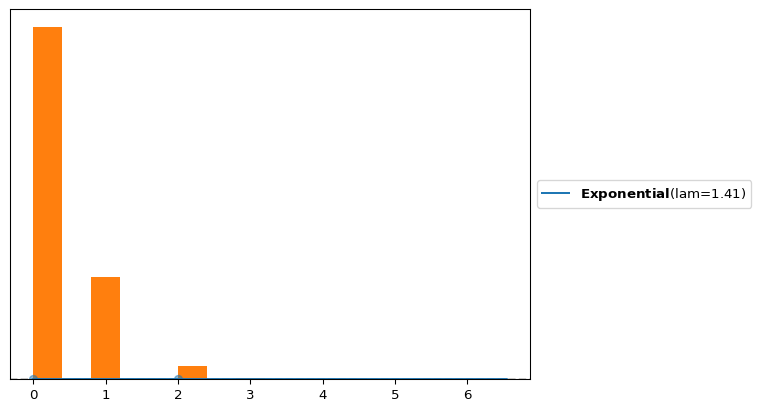

In [3]:
fig, ax = plt.subplots(ncols=2)


ax[0].hist(construct_games_played["number_of_seasons_played"])

pz.maxent(pz.InverseGamma(), lower=0.01, upper=8, ax=ax[1])
ax[1].set_xlim(0, 17.5)
ax[1].legend().set_visible(False)
plt.close("all")


seasons_gp_prior, ax = pz.maxent(pz.InverseGamma(), lower=0.01, upper=8)


seasons_m, seasons_c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[
        0,
        construct_games_played.select(
            pl.col("number_of_seasons_played").max()
        ).to_series()[0],
    ],
    lengthscale_range=[0.01, 8],
    cov_func="matern52",
)

plt.close("all")

# the short term prior is actually pretty decent
short_term_form, _ = pz.maxent(pz.InverseGamma(), lower=2, upper=6)

plt.xlim(0, 20)

med_form, ax = pz.maxent(pz.InverseGamma(), lower=12, upper=18)


plt.close("all")

construct_games_played.select(pl.col("games_played").mean())

within_m, within_c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[
        0,
        construct_games_played.select(pl.col("games_played").max()).to_series()[0],
    ],
    lengthscale_range=[1, 8],
    cov_func="matern52",
)

plt.close("all")

# effectively the difference between a player is about 2 touchdowns
touchdown_dist, ax = pz.maxent(pz.Exponential(), 0, 2)

plt.hist(data=construct_games_played, x="rec_tds_game")